In [1]:
import scanpy as sc
import pandas as pd
import pickle
import time
import anndata
import sklearn.metrics
import statistics
import graph_tool.all as gt
%matplotlib notebook
%pylab

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata=sc.read('mi_10x/adata_base.h5ad')

In [3]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=40)

In [4]:
cell_annotation= pd.read_table('matrix_mixology/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

In [5]:
sc.tl.umap(adata)

In [6]:
adata.write('beta_parameter/adata_10x.h5ad')

... storing 'cell_line' as categorical


In [2]:
adata=sc.read('beta_parameter/adata_10x.h5ad')

In [8]:
g = gt.Graph(directed=False)
adj=adata.uns['neighbors']['connectivities']
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [9]:
pickle.dump(g,open('beta_parameter/g.pkl','wb'),2)

In [5]:
a=time.time()
state1=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state2=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state3=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
b=time.time()
b-a

146.3785364627838

In [6]:
pickle.dump(state1,open('beta_parameter/state1_10x.pkl','wb'),2)
pickle.dump(state2,open('beta_parameter/state2_10x.pkl','wb'),2)
pickle.dump(state3,open('beta_parameter/state3_10x.pkl','wb'),2)

In [3]:
state1=pickle.load(open('beta_parameter/state1_10x.pkl','rb'))
state2=pickle.load(open('beta_parameter/state2_10x.pkl','rb'))
state3=pickle.load(open('beta_parameter/state3_10x.pkl','rb'))

<IPython.core.display.Javascript object>


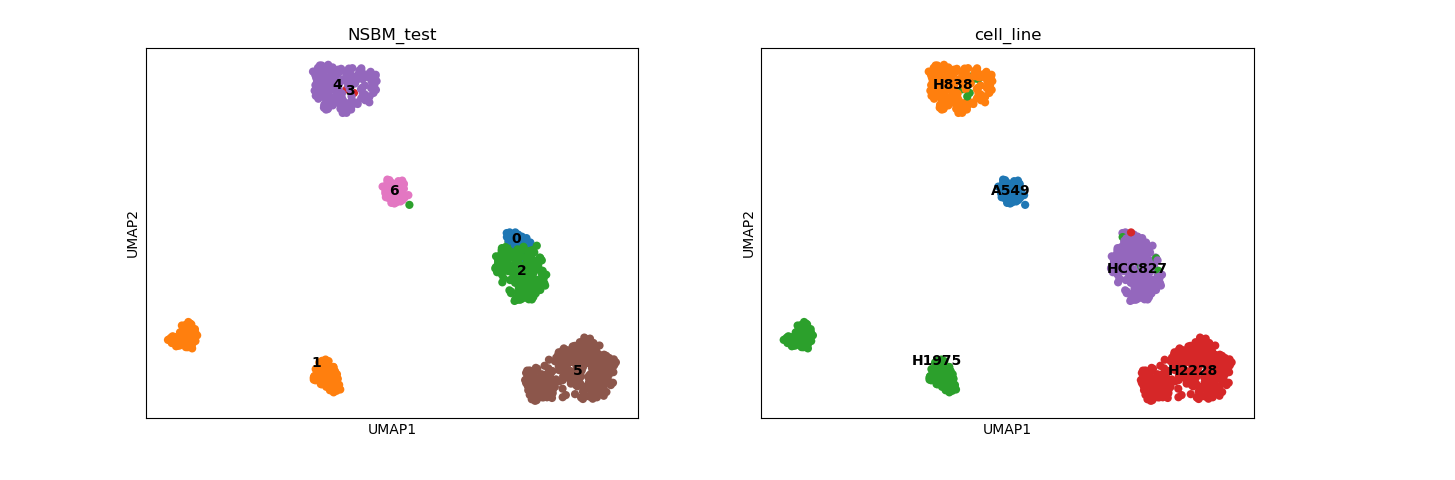

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,1,1,24
1,0,0,127,0,0
2,1,0,3,0,164
3,0,0,2,0,0
4,0,176,5,0,0
5,0,0,0,295,0
6,61,0,0,0,0


In [10]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state2.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

<IPython.core.display.Javascript object>


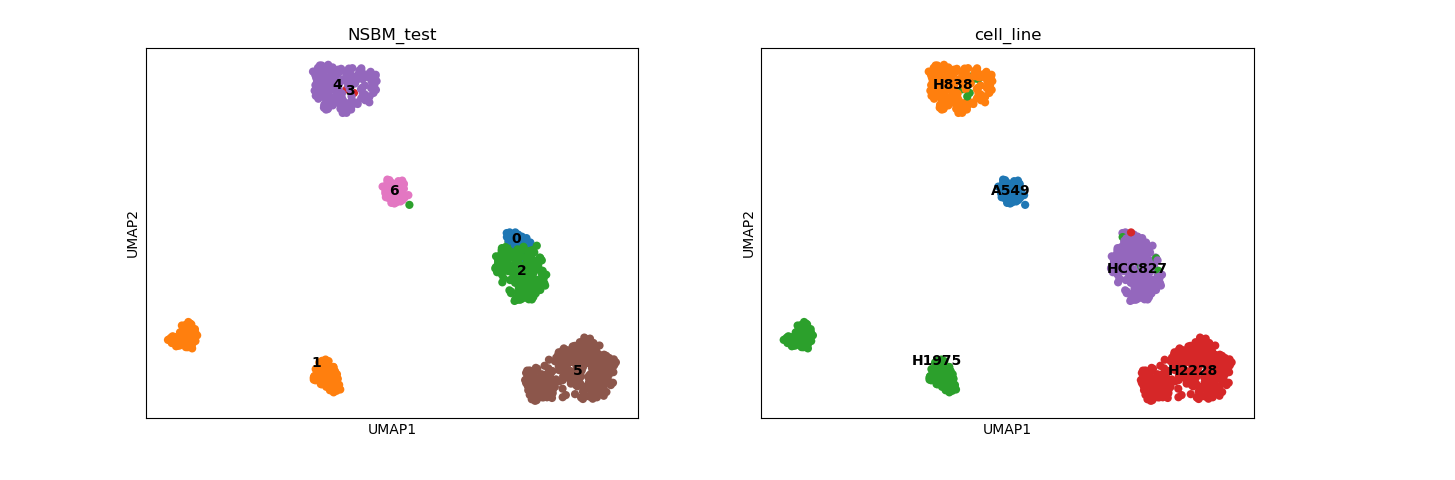

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,1,1,24
1,0,0,127,0,0
2,1,0,3,0,164
3,0,0,2,0,0
4,0,176,5,0,0
5,0,0,0,295,0
6,61,0,0,0,0


In [9]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state2.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

<IPython.core.display.Javascript object>


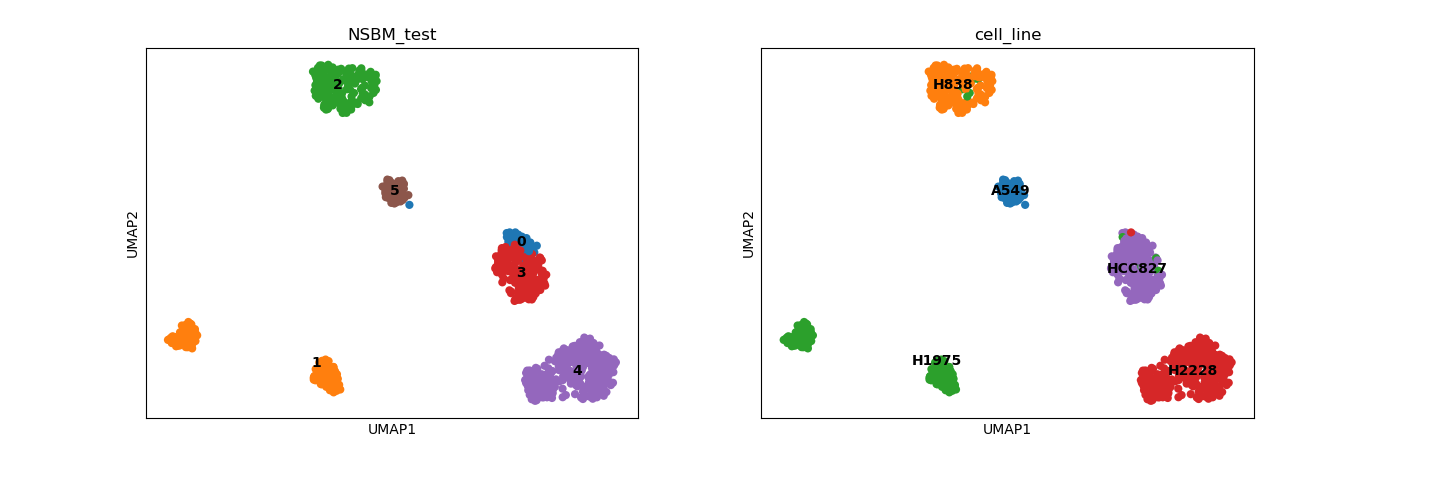

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,1,0,1,1,36
1,0,0,127,0,0
2,0,176,7,0,0
3,0,0,3,0,152
4,0,0,0,295,0
5,61,0,0,0,0


In [10]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state3.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [25]:
bs = state2.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state2.copy(bs=bs, sampling=True)
a=time.time()
state.mcmc_sweep(niter=100000)
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state2_sweep_10x.pkl','wb'),2)
state

289.4397814273834


<NestedBlockState object, with base <BlockState object with 80 blocks (76 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges, 1 internal edge property, at 0x7f78f7b26f10>, at 0x7f78f7637150>, and 10 levels of sizes [(860, 76), (76, 18), (18, 6), (6, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f78f7637090>

In [26]:
states2=pickle.load(open('beta_parameter/state2_sweep_10x.pkl','rb'))

<IPython.core.display.Javascript object>


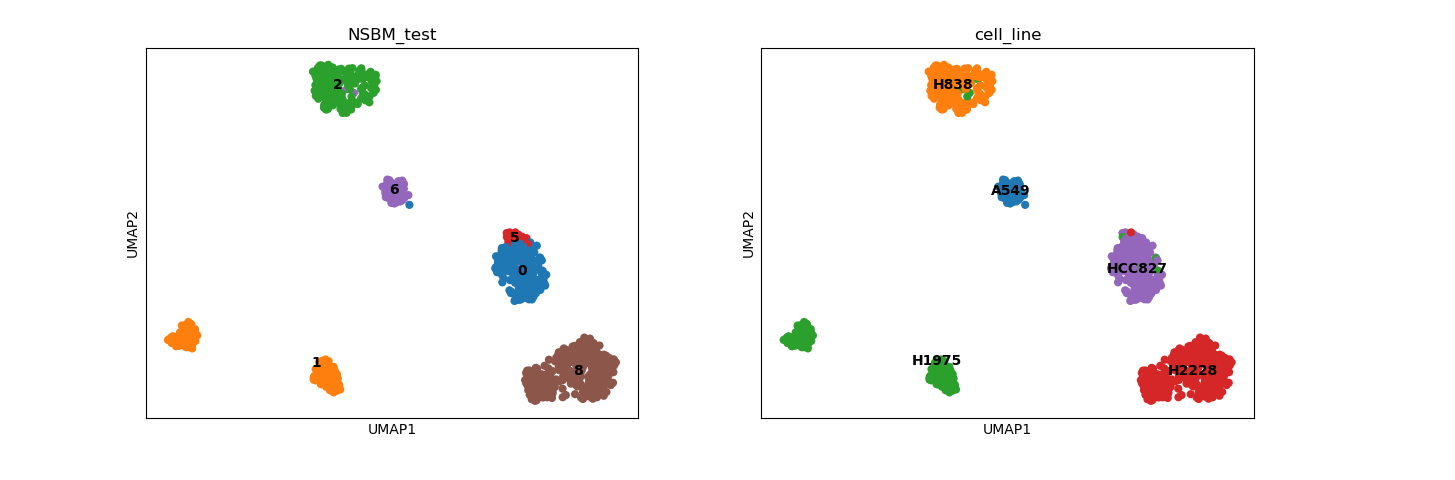

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,1,0,3,0,167
1,0,0,127,0,0
2,0,176,5,0,0
5,0,0,1,1,21
6,61,0,2,0,0
8,0,0,0,295,0


In [28]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(states2.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### equilibrate state 2

In [11]:
bs = state2.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state2.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(state,wait=1000,nbreaks=2,epsilon=0,mcmc_args=dict(niter=10))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state2_equilibrate_10x.pkl','wb'),2)
state

500.15526962280273


<NestedBlockState object, with base <BlockState object with 146 blocks (82 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges, 1 internal edge property, at 0x7f790d8de9d0>, at 0x7f78fcbb09d0>, and 10 levels of sizes [(860, 82), (82, 21), (21, 7), (7, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f78fcbac990>

In [14]:
estate2=pickle.load(open('beta_parameter/state2_equilibrate_10x.pkl','rb'))

<IPython.core.display.Javascript object>


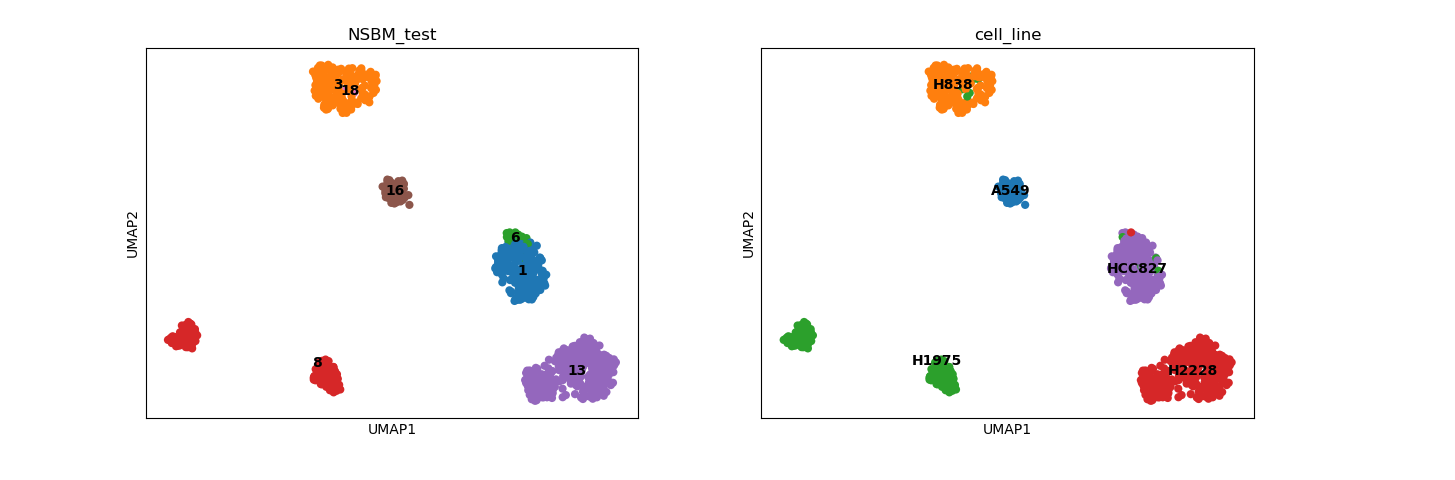

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,0,0,3,0,169
3,0,176,5,0,0
6,0,0,1,1,19
8,0,0,127,0,0
13,0,0,0,295,0
16,62,0,0,0,0
18,0,0,2,0,0


In [16]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate2.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### anneal state 3 post equilirbate

In [17]:
bs = estate2.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = estate2.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=5)
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state2_anneal100_5a_post_eq.pkl','wb'),2)
state

225.31288599967957


<NestedBlockState object, with base <BlockState object with 143 blocks (81 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges, 1 internal edge property, at 0x7f790c03d710>, at 0x7f78fc894410>, and 10 levels of sizes [(860, 81), (81, 21), (21, 7), (7, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f78fc90b7d0>

In [18]:
state100_5a=pickle.load(open('beta_parameter/state2_anneal100_5a_post_eq.pkl','rb'))

<IPython.core.display.Javascript object>


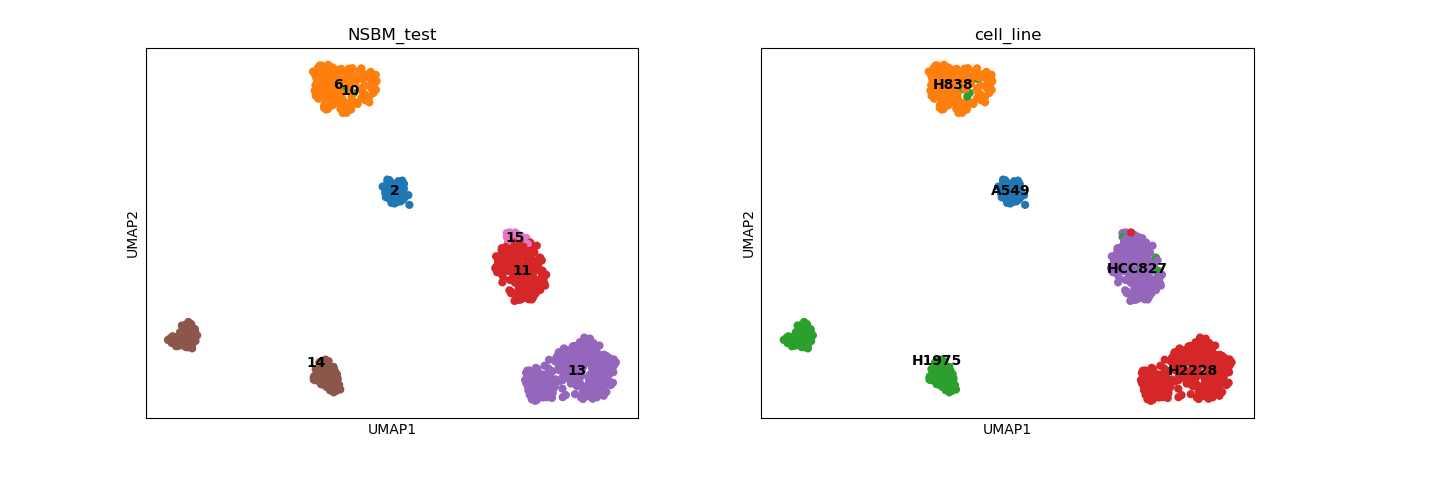

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
2,62,0,0,0,0
6,0,176,5,0,0
10,0,0,2,0,0
11,0,0,3,0,169
13,0,0,0,295,0
14,0,0,127,0,0
15,0,0,1,1,19


In [19]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_5a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

# mcmc anneal state 3
### 1_100 5

In [5]:
bs = state3.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state3.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(nbreaks=3))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal100_5a_nbreaks3.pkl','wb'),2)
state

422.1115825176239


<NestedBlockState object, with base <BlockState object with 150 blocks (90 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges, 1 internal edge property, at 0x7fdd63380810>, at 0x7fdd6276a650>, and 10 levels of sizes [(860, 90), (90, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fdd6275a650>

In [7]:
state100_5a=pickle.load(open('beta_parameter/state3_anneal100_5a_nbreaks3.pkl','rb'))

<IPython.core.display.Javascript object>


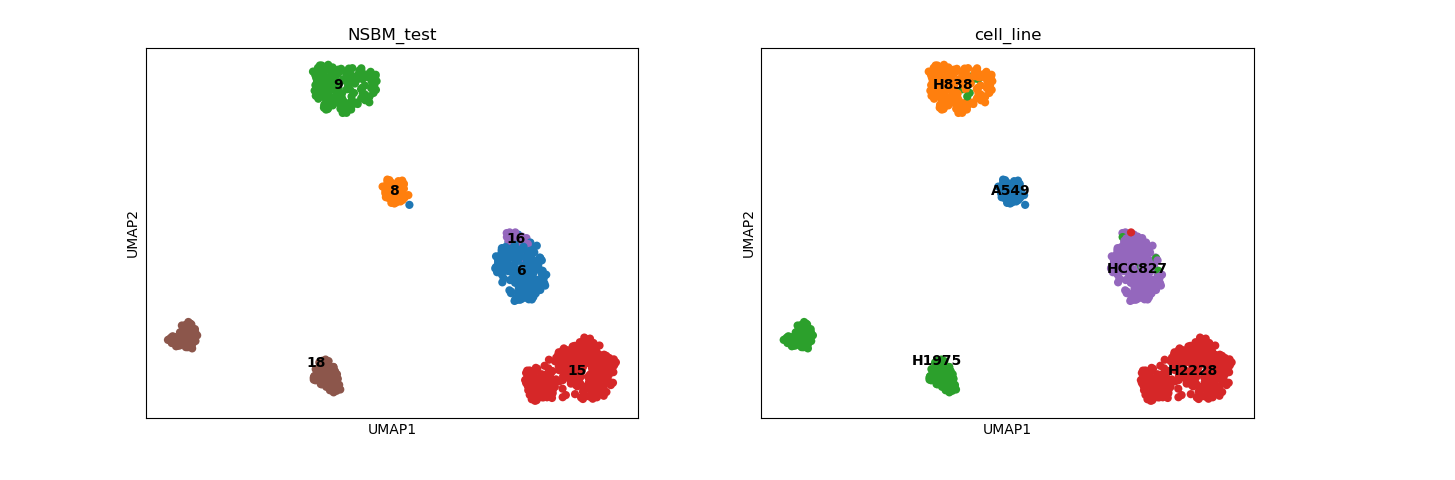

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
6,1,0,3,0,170
8,61,0,0,0,0
9,0,176,7,0,0
15,0,0,0,295,0
16,0,0,1,1,18
18,0,0,127,0,0


In [8]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_5a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [26]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal100_5b.pkl','wb'),2)
state

142.66325426101685


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd42f6cc0>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd42f6cf8>

In [27]:
state100_5b=pickle.load(open('beta_parameter/state3_anneal100_5b.pkl','rb'))

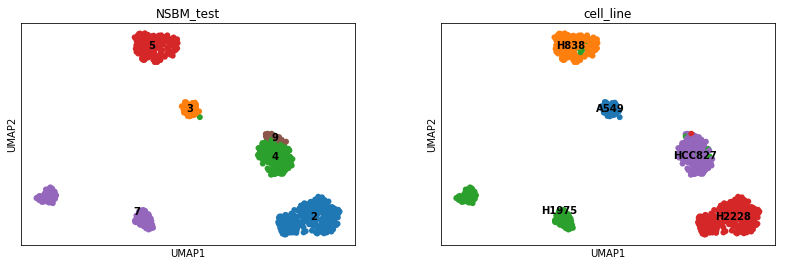

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
2,0,0,0,295,0
3,61,0,0,0,0
4,1,0,3,0,166
5,0,176,7,0,0
7,0,0,127,0,0
9,0,0,1,1,22


In [28]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_5b.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [29]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal100_5c.pkl','wb'),2)
state

155.78265929222107


<NestedBlockState object, with base <BlockState object with 79 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd42a8240>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd42a82e8>

In [30]:
state100_5c=pickle.load(open('beta_parameter/state3_anneal100_5c.pkl','rb'))

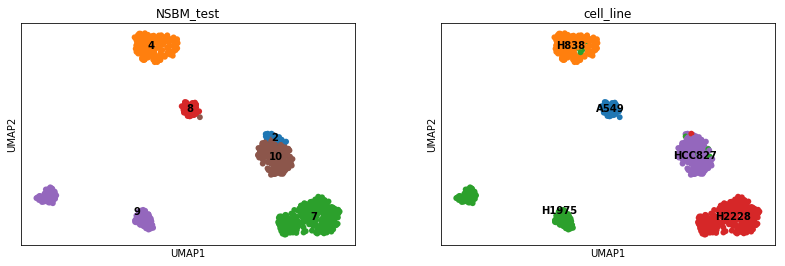

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
2,0,0,1,1,22
4,0,176,7,0,0
7,0,0,0,295,0
8,61,0,0,0,0
9,0,0,127,0,0
10,1,0,3,0,166


In [31]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_5c.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### 1_100 10

In [25]:
bs = state3.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state3.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal100_10a.pkl','wb'),2)
state

328.4814028739929


<NestedBlockState object, with base <BlockState object with 81 blocks (80 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7f0c908f2c90>, at 0x7f0c8e6e7190>, and 10 levels of sizes [(860, 80), (80, 20), (20, 7), (7, 5), (5, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1)] at 0x7f0c8e6e7110>

In [26]:
state100_10a=pickle.load(open('beta_parameter/state3_anneal100_10a.pkl','rb'))

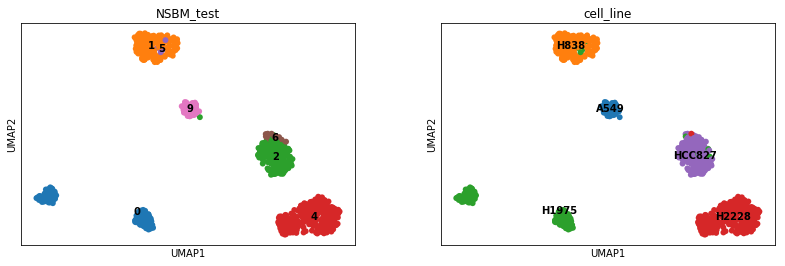

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,127,0,0
1,0,175,4,0,0
2,1,0,3,0,168
4,0,0,0,295,0
5,0,1,3,0,0
6,0,0,1,1,20
9,61,0,0,0,0


In [29]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_10a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [35]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal100_10b.pkl','wb'),2)
state

294.4677209854126


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd427df28>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd427dcc0>

In [36]:
state100_10b=pickle.load(open('beta_parameter/state3_anneal100_10b.pkl','rb'))

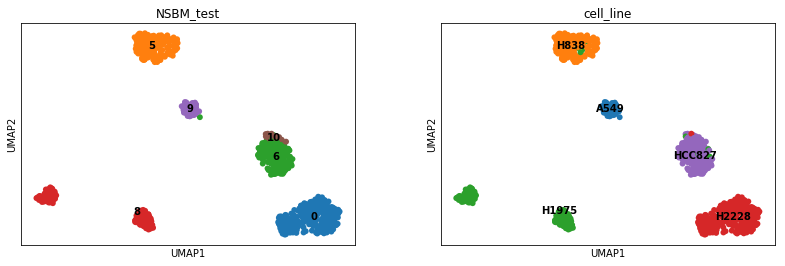

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,0,295,0
5,0,176,7,0,0
6,1,0,3,0,167
8,0,0,127,0,0
9,61,0,0,0,0
10,0,0,1,1,21


In [66]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_10b.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [38]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal100_10c.pkl','wb'),2)
state

287.03257608413696


<NestedBlockState object, with base <BlockState object with 79 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd4226550>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd42265c0>

In [39]:
state100_10c=pickle.load(open('beta_parameter/state3_anneal100_10c.pkl','rb'))

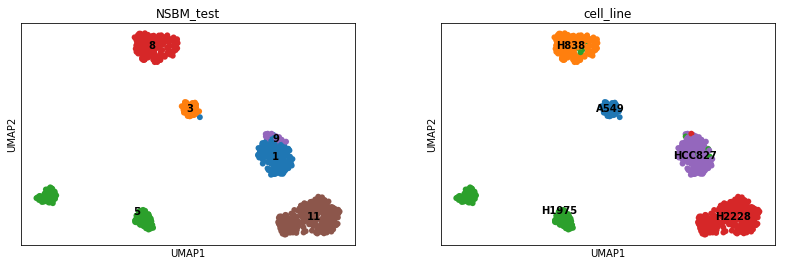

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,1,0,3,0,168
3,61,0,0,0,0
5,0,0,127,0,0
8,0,176,7,0,0
9,0,0,1,1,20
11,0,0,0,295,0


In [65]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_10c.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### 1_1000 5

In [41]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,1000), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal1000_5a.pkl','wb'),2)
state

136.9997639656067


<NestedBlockState object, with base <BlockState object with 78 blocks (76 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd41ecf98>, and 10 levels of sizes [(860, 76), (76, 21), (21, 7), (7, 5), (5, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd41ecf60>

In [42]:
state1000_5a=pickle.load(open('beta_parameter/state3_anneal1000_5a.pkl','rb'))

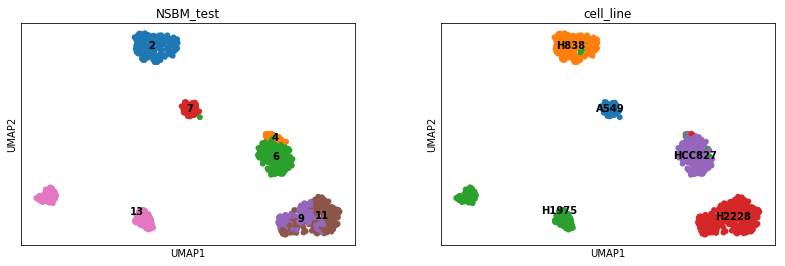

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
2,0,176,7,0,0
4,0,0,1,1,20
6,1,0,3,0,168
7,61,0,0,0,0
9,0,0,0,116,0
11,0,0,0,179,0
13,0,0,127,0,0


In [64]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state1000_5a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [44]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,1000), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal1000_5b.pkl','wb'),2)
state

121.16451025009155


<NestedBlockState object, with base <BlockState object with 78 blocks (76 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd41b7438>, and 10 levels of sizes [(860, 76), (76, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd41b74e0>

In [45]:
state1000_5b=pickle.load(open('beta_parameter/state3_anneal1000_5b.pkl','rb'))

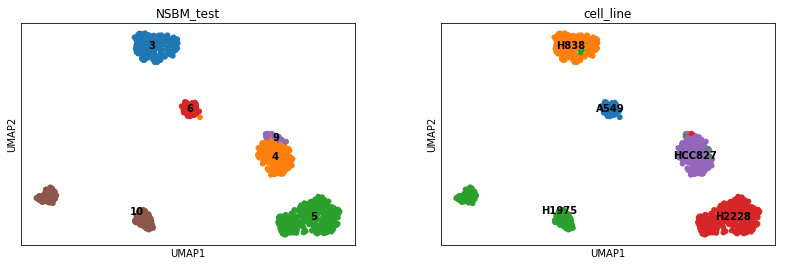

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
3,0,176,7,0,0
4,1,0,3,0,168
5,0,0,0,295,0
6,61,0,0,0,0
9,0,0,1,1,20
10,0,0,127,0,0


In [63]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state1000_5b.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [47]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,1000), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal1000_5c.pkl','wb'),2)
state

127.36046314239502


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd4185e80>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd4185d68>

In [48]:
state1000_5c=pickle.load(open('beta_parameter/state3_anneal1000_5c.pkl','rb'))

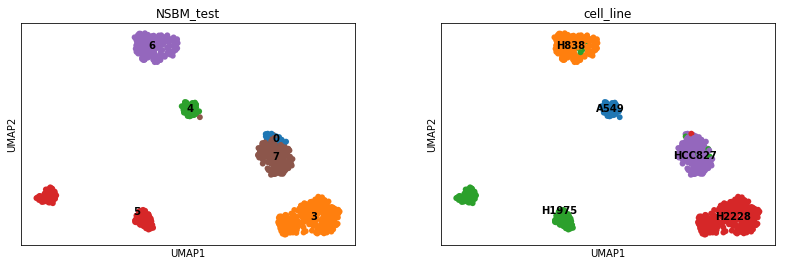

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,1,1,20
3,0,0,0,295,0
4,61,0,0,0,0
5,0,0,127,0,0
6,0,176,7,0,0
7,1,0,3,0,168


In [62]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state1000_5c.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### 1_1000 10

In [50]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,1000), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal1000_10a.pkl','wb'),2)
state

232.9055519104004


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd414aba8>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd414abe0>

In [51]:
state1000_10a=pickle.load(open('beta_parameter/state3_anneal1000_10a.pkl','rb'))

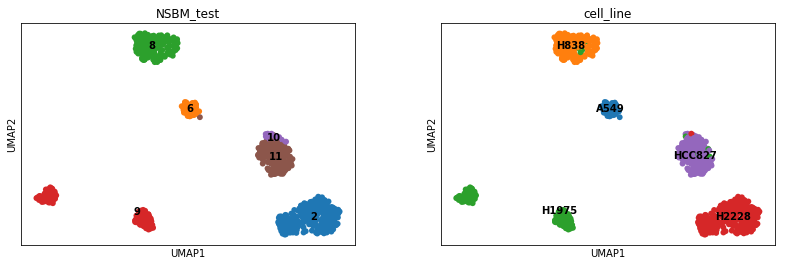

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
2,0,0,0,295,0
6,61,0,0,0,0
8,0,176,7,0,0
9,0,0,127,0,0
10,0,0,1,1,21
11,1,0,3,0,167


In [61]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state1000_10a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [53]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,1000), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal1000_10b.pkl','wb'),2)
state

201.3955852985382


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd4109320>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd4109278>

In [54]:
state1000_10b=pickle.load(open('beta_parameter/state3_anneal1000_10b.pkl','rb'))

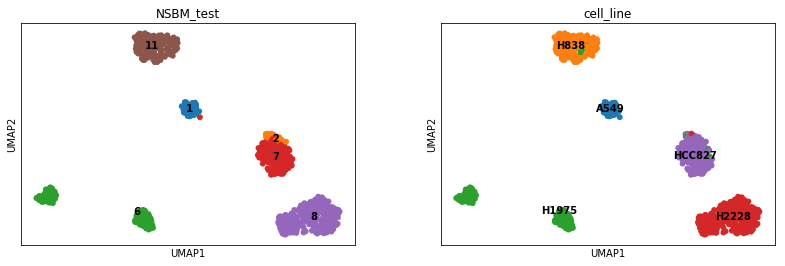

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,61,0,0,0,0
2,0,0,1,1,20
6,0,0,127,0,0
7,1,0,3,0,168
8,0,0,0,295,0
11,0,176,7,0,0


In [60]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state1000_10b.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [56]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,1000), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal1000_10c.pkl','wb'),2)
state

224.64553833007812


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd4068da0>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd4068b70>

In [57]:
state1000_10c=pickle.load(open('beta_parameter/state3_anneal1000_10c.pkl','rb'))

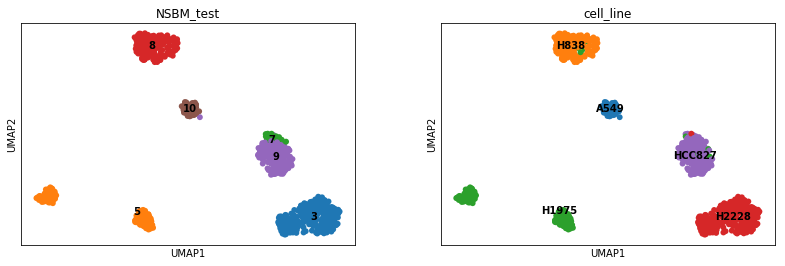

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
3,0,0,0,295,0
5,0,0,127,0,0
7,0,0,1,1,25
8,0,176,7,0,0
9,1,0,3,0,163
10,61,0,0,0,0


In [59]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state1000_10c.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### 1_10000 5

In [68]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,10000), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal10000_5a.pkl','wb'),2)
state

118.34099102020264


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfd405cf98>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfd405c978>

In [69]:
state10000_5a=pickle.load(open('beta_parameter/state3_anneal10000_5a.pkl','rb'))

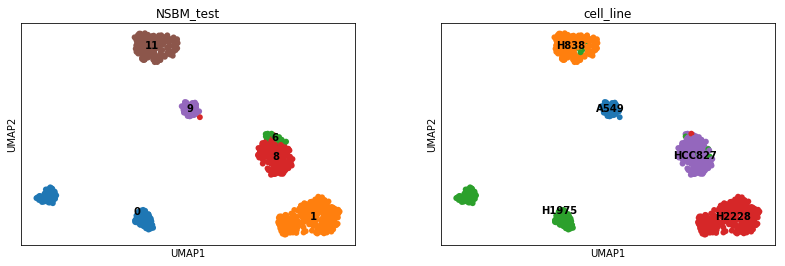

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,127,0,0
1,0,0,0,295,0
6,0,0,1,1,22
8,1,0,3,0,166
9,61,0,0,0,0
11,0,176,7,0,0


In [70]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state10000_5a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [71]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,10000), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal10000_5b.pkl','wb'),2)
state

131.96113204956055


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfb718db70>, and 10 levels of sizes [(860, 77), (77, 22), (22, 7), (7, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfb718db00>

In [72]:
state10000_5b=pickle.load(open('beta_parameter/state3_anneal10000_5b.pkl','rb'))

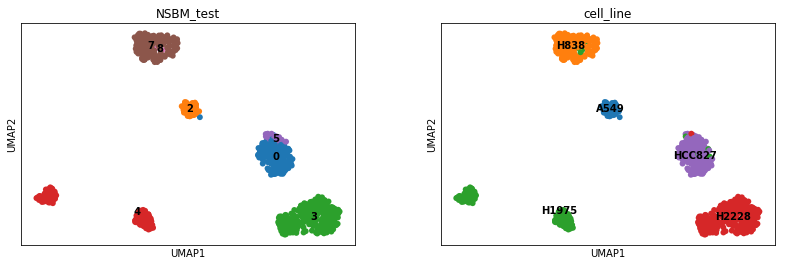

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,1,0,3,0,167
2,61,0,0,0,0
3,0,0,0,295,0
4,0,0,127,0,0
5,0,0,1,1,21
7,0,176,5,0,0
8,0,0,2,0,0


In [73]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state10000_5b.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [74]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,10000), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal10000_5c.pkl','wb'),2)
state

125.25884866714478


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfb70e3e10>, and 10 levels of sizes [(860, 77), (77, 21), (21, 8), (8, 5), (5, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfb70e3e80>

In [75]:
state10000_5c=pickle.load(open('beta_parameter/state3_anneal10000_5c.pkl','rb'))

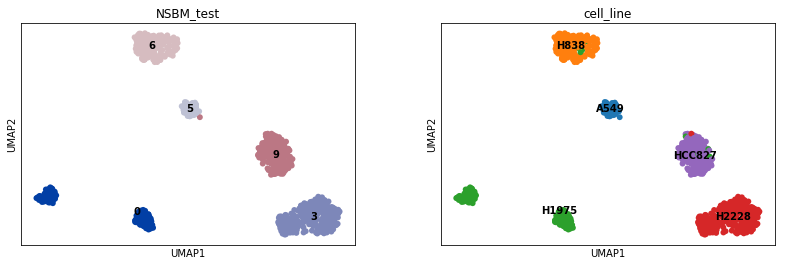

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,0,127,0,0
3,0,0,0,295,0
5,61,0,0,0,0
6,0,176,7,0,0
9,1,0,4,1,188


In [96]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state10000_5c.project_level(3).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### 1_10000 10

In [77]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,10000), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal10000_10a.pkl','wb'),2)
state

227.8657145500183


<NestedBlockState object, with base <BlockState object with 78 blocks (76 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfb709e438>, and 10 levels of sizes [(860, 76), (76, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfb709e2e8>

In [78]:
state10000_10a=pickle.load(open('beta_parameter/state3_anneal10000_10a.pkl','rb'))

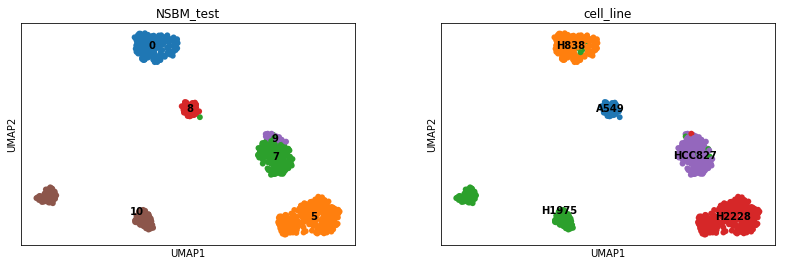

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,176,7,0,0
5,0,0,0,295,0
7,1,0,3,0,167
8,61,0,0,0,0
9,0,0,1,1,21
10,0,0,127,0,0


In [79]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state10000_10a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [80]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,10000), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal10000_10b.pkl','wb'),2)
state

261.0639383792877


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfb7087c88>, and 10 levels of sizes [(860, 77), (77, 21), (21, 8), (8, 5), (5, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfb70870b8>

In [81]:
state10000_10b=pickle.load(open('beta_parameter/state3_anneal10000_10b.pkl','rb'))

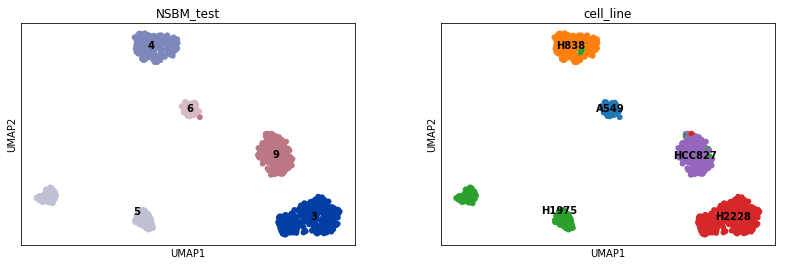

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
3,0,0,0,295,0
4,0,176,7,0,0
5,0,0,127,0,0
6,61,0,0,0,0
9,1,0,4,1,188


In [90]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state10000_10b.project_level(3).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [83]:
state=state3.copy()
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,10000), niter=10,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state3_anneal10000_10c.pkl','wb'),2)
state

268.53105068206787


<NestedBlockState object, with base <BlockState object with 78 blocks (77 nonempty), for graph <Graph object, undirected, with 860 vertices and 18307 edges at 0x7fbfd4675048>, at 0x7fbfb7041a20>, and 10 levels of sizes [(860, 77), (77, 20), (20, 6), (6, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fbfb7041da0>

In [84]:
state10000_10c=pickle.load(open('beta_parameter/state3_anneal10000_10c.pkl','rb'))

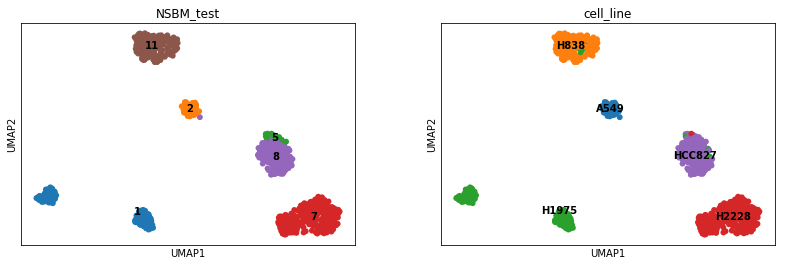

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,0,0,127,0,0
2,61,0,0,0,0
5,0,0,1,1,21
7,0,0,0,295,0
8,1,0,3,0,167
11,0,176,7,0,0


In [85]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state10000_10c.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [2]:
gt.__version__

'2.30 (commit dbbccdf7, Mon Mar 23 11:15:48 2020 +0000)'